In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#  Packages & Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import sklearn as skl
import warnings
import statsmodels.api as sm

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, validation_curve, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler, LabelEncoder, scale, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.feature_selection import RFE,SelectFromModel

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import make_classification

from xgboost import XGBClassifier 

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')


### Helper Functions

In [3]:
%load_ext autoreload
%aimport data_prep
%run data_prep.py
%autoreload 1

### Load Datasets

In [4]:
train_data = pd.read_csv("training_set_values.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_data = pd.read_csv("test_set_values.csv")

### Columns cleaning

In [5]:
#Join Labels with Train data
train_data = addLabelToTrainData(train_data, train_labels)

#Drop id and recorded from train dataset 
train_data = prepareCols(train_data)
test_data = prepareCols(test_data)


`status_group` added to train_data 

['id', 'recorded_by', 'scheme_name', 'ward', 'wpt_name', 'subvillage', 'waterpoint_type_group'] removed from dataset 

['id', 'recorded_by', 'scheme_name', 'ward', 'wpt_name', 'subvillage', 'waterpoint_type_group'] removed from dataset 



### Shortlisting columns

In [6]:
train_data_transformed = train_data.copy()

# installer
train_data_transformed = shortlist_installer(train_data_transformed)

# funder
train_data_transformed = shortlist_funder(train_data_transformed)

# lga
train_data_transformed = shortlist_lga(train_data_transformed)

`installer` shortlisted to {'Commu', 'DANIDA', 'DWE', 'Government', 'RWE', 'other'} only 

`funder` shortlisted to {'Government Of Tanzania','Danida','Hesawa','Rwssp','World Bank','Kkkt','World Vision','Unicef','Tasaf','District Council', 'other'} only 

`lga` shortlisted to {'Njombe','Arusha Rural','Moshi Rural','Bariadi','Rungwe','Kilosa','Kasulu','Mbozi','Meru','Bagamoyo', 'other'} only 



### Conversions
#### Convert `construction_year`

In [7]:
# construction_year - converts it to years elapsed (AKA age) -- (zeroes ignored)
train_data_transformed = convert_construction_year(train_data_transformed)

`construction_year` converted to `age`, which is elapsed years (zeroes ignored) 



### ^^^^^^^^^^^^^^^^^^^^^^^^^^ What to do with zeores here ? (summary  ↓ ) -- currently imputing with median

In [8]:
zeroes =    train_data_transformed['age'][train_data_transformed['age'] == 0].count() / train_data_transformed['age'].count()
mean = np.mean(train_data_transformed['age'][train_data_transformed['age'] != 0])
median = np.median(train_data_transformed['age'][train_data_transformed['age'] != 0])

print("% of zeroes: {}".format(zeroes))

print("mean: {}".format(mean))


print("median: {}".format(median))

# impute with median
train_data_transformed[train_data_transformed['age'] == 0][["age"]] = median

% of zeroes: 0.34863636363636363
mean: 22.185314414204854
median: 19.0


#### Convert `date_recorded`

In [9]:
train_data_transformed = convert_date_recorded(train_data_transformed)

`date_recorded` converted to `days_since_recoreded`, which is elapsed days (zeroes ignored) 



In [10]:
### Mapping long and lat to city

### Binning

In [11]:
train_data_transformed = bin_feature(train_data_transformed, "days_since_recoreded", 10)

`days_since_recoreded` has been binned to 10 categories:
IntervalIndex([(1916.932, 2327.8], (2327.8, 2734.6], (2734.6, 3141.4], (5175.4, 5582.2], (5582.2, 5989.0]]
              closed='right',
              dtype='interval[float64]')




In [12]:
numerical = ['amount_tsh', 'gps_height', 'num_private', 'population']
other = ['longitude', 'latitude', "status_code"]
categorical = list(set(train_data_transformed.columns) - set(numerical) - set(other))
categorical

['installer',
 'permit',
 'region_code',
 'lga',
 'water_quality',
 'extraction_type_class',
 'status_group',
 'management',
 'source',
 'district_code',
 'scheme_management',
 'region',
 'source_type',
 'days_since_recoreded',
 'quality_group',
 'quantity',
 'age',
 'management_group',
 'source_class',
 'payment_type',
 'extraction_type_group',
 'waterpoint_type',
 'quantity_group',
 'public_meeting',
 'basin',
 'funder',
 'payment',
 'extraction_type']

# Correlation matrix

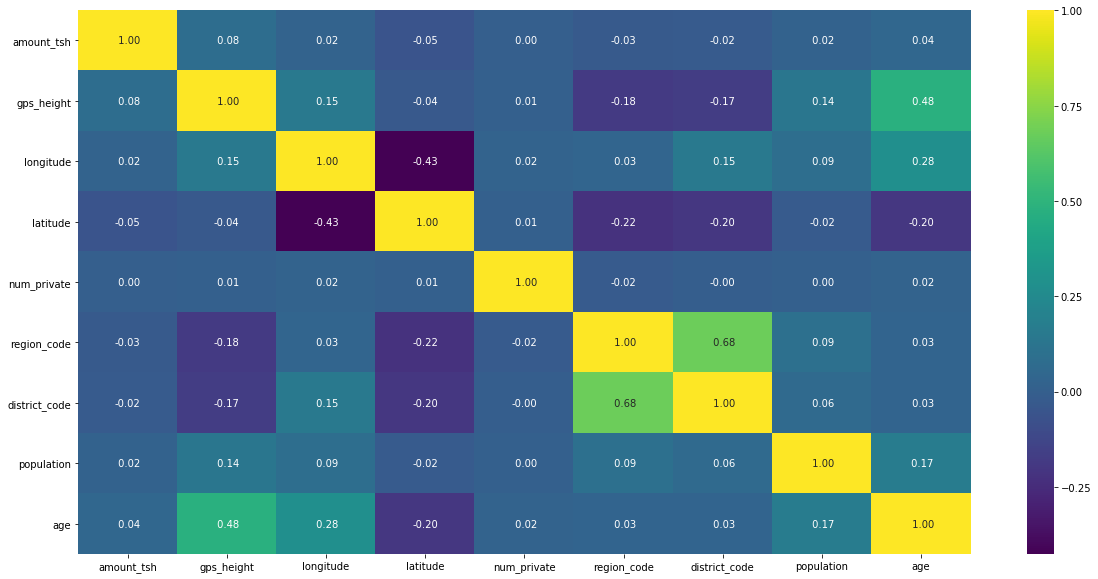

In [13]:
plt.pyplot.figure(figsize=(20,10))
sns.heatmap(train_data_transformed.corr(),cbar=True,fmt =' .2f', annot=True, cmap='viridis')

# Hot Encode & Save Data

In [14]:
labels_prepared = train_data_transformed[["status_group"]]
train_data_transformed = train_data_transformed.drop(columns=["status_group"])
train_data_transformed = onehot_encode(train_data_transformed)
train_data_transformed.to_csv("train_data_prepared.csv")
labels_prepared.to_csv("labels_prepared.csv")